In [2]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from IPython.display import display

In [3]:
# 读取训练集和测试集为 DataFrame
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print train_data.shape
display(train_data.head(1))
display(train_data.info())

print test_data.shape
display(test_data.head(1))
display(test_data.info())

#NaN
train_data.fillna(value=-999,inplace=True)
test_data.fillna(value=-999,inplace=True)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

None

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

None

In [4]:
# dtypes: float64(3), int64(35), object(43)
# 可以看出训练集有 38 列数值型数据，43 列字符串类型的数据
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,-119.596575,10516.828082,6.099315,5.575342,1971.267808,1984.865753,97.643151,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,409.115115,9981.264932,1.382997,1.112799,30.202904,20.645407,198.080250,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,-999.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,-999.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
# preprocessing.LabelEncoder: Encode labels with value between 0 and n_classes-1.
from sklearn import preprocessing

# 包含43列字符串类型的数据
train_str = train_data.select_dtypes(include=['object'])
test_str = test_data.select_dtypes(include=['object'])

# train_str.columns.values 获取列名称，返回array类型
column_names = train_str.columns.values
print column_names
train_data.drop(column_names, axis=1, inplace=True)
test_data.drop(column_names, axis=1, inplace=True)

print train_data.shape, test_data.shape

['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC'
 'CentralAir' 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu'
 'GarageType' 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive'
 'PoolQC' 'Fence' 'MiscFeature' 'SaleType' 'SaleCondition']
(1460, 38) (1459, 37)


In [6]:
train_str_dummies = pd.get_dummies(train_str)
test_str_dummies = pd.get_dummies(test_str)

# 选择训练集和测试集都有的列
columns_dum = list(set(train_str_dummies) & set(test_str_dummies))

train_str_dummies = train_str_dummies[columns_dum]
test_str_dummies = test_str_dummies[columns_dum]

train_data_new = pd.merge(train_data,train_str_dummies,left_index=True,right_index=True)
test_data_new = pd.merge(test_data,test_str_dummies,left_index=True,right_index=True)

print train_data_new.shape, test_data_new.shape

(1460, 287) (1459, 286)


(array([   5.,   12.,   54.,  184.,  470.,  400.,  220.,   90.,   19.,    6.]),
 array([ 10.46024211,  10.7676652 ,  11.07508829,  11.38251138,
         11.68993448,  11.99735757,  12.30478066,  12.61220375,
         12.91962684,  13.22704994,  13.53447303]),
 <a list of 10 Patch objects>)

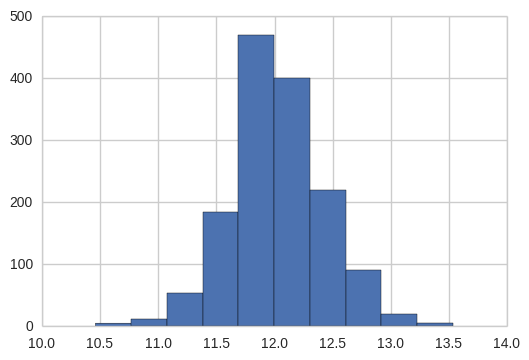

In [7]:
# 价格分布
plt.hist(np.log(train_data.SalePrice))

In [8]:
train_Y = train_data_new.SalePrice
train_X = train_data_new.drop(['Id', 'SalePrice'], axis=1)
test_X = test_data_new.drop(['Id'], axis=1)
test_Id = test_data_new.Id

del train_data
del train_data_new
del test_data_new

print train_X.shape, train_Y.shape, test_X.shape

(1460, 285) (1460,) (1459, 285)


In [9]:
train_X.head(1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Neighborhood_SawyerW,KitchenQual_Fa,RoofStyle_Hip,Functional_Maj1,GarageType_Detchd,Fence_GdWo,LotShape_IR1,LotShape_IR2,LotShape_IR3,SaleCondition_Alloca
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=100)
clf.fit(train_X, train_Y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = train_X.columns
feature_importance['importance'] = clf.feature_importances_

feature_importance.sort_values(by=['importance'], ascending=False)

,feature,importance
15,GrLivArea,0.020776
2,LotArea,0.020365
12,1stFlrSF,0.020296
34,MoSold,0.019982
10,BsmtUnfSF,0.019815
26,GarageArea,0.019391
1,LotFrontage,0.019310
11,TotalBsmtSF,0.019307
35,YrSold,0.018732
5,YearBuilt,0.018466


In [13]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=300)

forest.fit(train_X, train_Y)

forest_predictions = forest.predict(test_X).astype(int)
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": forest_predictions
    })

submission.to_csv("result/simple_RF_predictions_2_1.csv", index=False)

print "RandomForestClassifier Done."

RandomForestClassifier Done.
